# 05 – Ewaluacja na zbiorze testowym

Jednorazowa ocena zapisanego modelu na zbiorze testowym (bez trenowania). Metryki: accuracy, F1 macro, AR score, confusion matrix. Zapis wyników do results/.

## 1. Ścieżka projektu, ładowanie testu i preprocessingu

In [1]:
import sys
from pathlib import Path

root = Path.cwd()
if not (root / "src").is_dir():
    root = root.parent
sys.path.insert(0, str(root))

import numpy as np
import pandas as pd
from datasets import load_dataset
from src.preprocessing import PolishTextPreprocessor

dataset = load_dataset("allegro/klej-allegro-reviews")
test_df = dataset["test"].to_pandas()

preprocessor = PolishTextPreprocessor(remove_emoji=True, remove_stopwords=False)
test_df["text_clean"] = preprocessor.preprocess_series(test_df["text"])
test_df["text_clean"] = test_df["text_clean"].fillna("")

def to_string_list(ser):
    return [str(x) if not (isinstance(x, float) and np.isnan(x)) else "" for x in ser.tolist()]

test_texts = to_string_list(test_df["text_clean"])
y_test = test_df["rating"].values.astype(int)
print("Test:", len(test_texts), "próbek | y_test (1-5):", y_test.min(), "-", y_test.max())

Test: 1006 próbek | y_test (1-5): 1 - 5


## 2. Embeddingi testowe i przewidywania

In [2]:
from sentence_transformers import SentenceTransformer
import joblib

encoder = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
X_test = encoder.encode(test_texts, batch_size=64, show_progress_bar=True)

classifier = joblib.load(root / "models" / "best_classifier.pkl")
y_pred_01 = classifier.predict(X_test)
y_pred = y_pred_01 + 1  # 1-5
print("X_test:", X_test.shape, "| Przewidywania: 1-5")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

X_test: (1006, 384) | Przewidywania: 1-5


## 3. Metryki i AR score

In [3]:
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, confusion_matrix, classification_report

def ar_score(y_true, y_pred):
    y_true = (np.asarray(y_true) - 1.0) / 4.0
    y_pred = (np.asarray(y_pred) - 1.0) / 4.0
    wmae = 0.0
    for val in np.unique(y_true):
        mask = y_true == val
        wmae += mean_absolute_error(y_true[mask], y_pred[mask])
    wmae /= len(np.unique(y_true))
    return 1.0 - wmae

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
ar = ar_score(y_test, y_pred)
print("Test set:")
print(f"  Accuracy:   {acc:.4f}")
print(f"  F1 macro:   {f1:.4f}")
print(f"  AR score:   {ar:.4f}")

Test set:
  Accuracy:   0.4980
  F1 macro:   0.4372
  AR score:   0.7965


## 4. Confusion matrix i raport

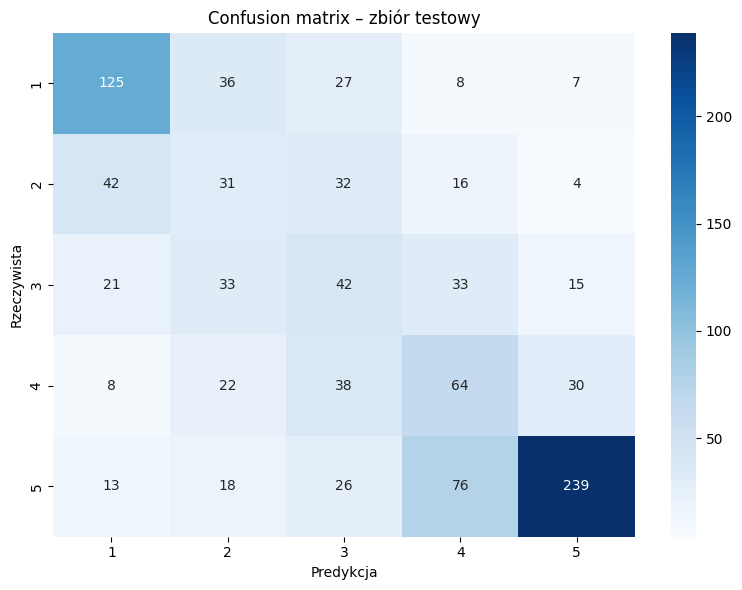

              precision    recall  f1-score   support

           1       0.60      0.62      0.61       203
           2       0.22      0.25      0.23       125
           3       0.25      0.29      0.27       144
           4       0.32      0.40      0.36       162
           5       0.81      0.64      0.72       372

    accuracy                           0.50      1006
   macro avg       0.44      0.44      0.44      1006
weighted avg       0.54      0.50      0.51      1006



In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
ax.set_xlabel("Predykcja")
ax.set_ylabel("Rzeczywista")
ax.set_title("Confusion matrix – zbiór testowy")
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, target_names=["1", "2", "3", "4", "5"]))

## 5. Zapis wyników do results/

In [5]:
import json

results_dir = root / "results"
results_dir.mkdir(parents=True, exist_ok=True)

metrics_test = {
    "dataset": "test",
    "n_samples": int(len(y_test)),
    "accuracy": float(acc),
    "f1_macro": float(f1),
    "ar_score": float(ar),
}
path = results_dir / "metrics_test.json"
with open(path, "w", encoding="utf-8") as f:
    json.dump(metrics_test, f, indent=2)
print(f"Zapisano: {path}")

Zapisano: /Users/jakub/sentiment-classifier-pl/results/metrics_test.json
